In [34]:
import numpy as np
import pandas as pd
import cv2
from scipy.spatial import distance
import os

### Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [4]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

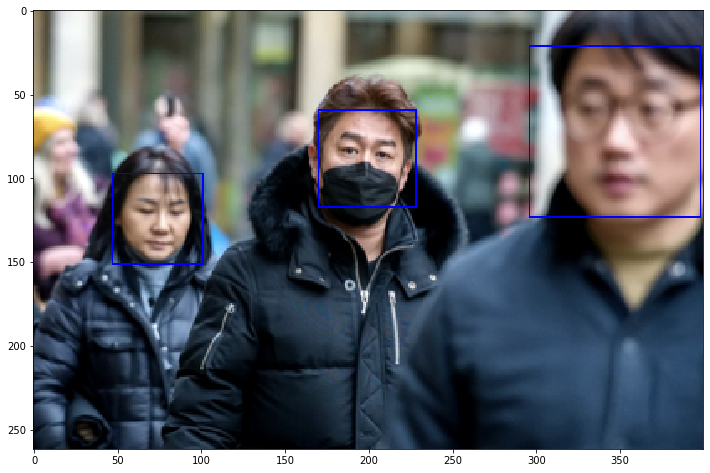

In [5]:
import matplotlib.pyplot as plt
# Trying it out on a sample image
img = cv2.imread("C:/Users/jites/Downloads/Face mask detection kaggle/images/maksssksksss244.png")
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    #colored output image
#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img, (x,y), (x+w, y+h), (0,0,255), 1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

## Detecting social distancing violations
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [6]:
MIN_DISTANCE = 130

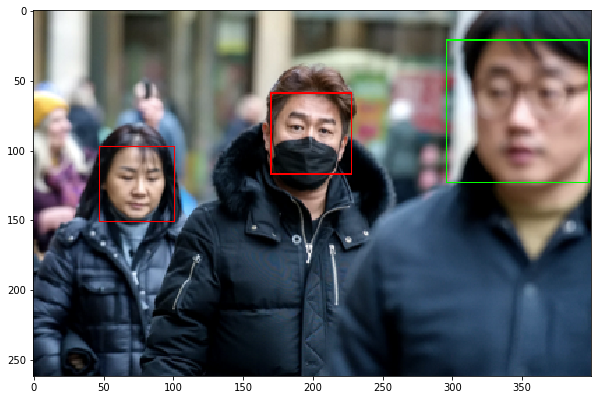

In [7]:
if len(faces) >= 2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces) - 1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            
            if(dist < MIN_DISTANCE):
                label[i] = 1
                label[j] = 1
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if(label[i] == 1):
            cv2.rectangle(new_img, (x,y), (x+w, y+h), (255,0,0), 1)
        else:
            cv2.rectangle(new_img, (x,y), (x+w, y+h), (0,255,0), 1)
            
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
    
else:
    print("No. of faces detected is less than 2")

**Red box shows violation of social distancing**

## Using VGG19 for mask detection

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_dir = 'C:/Users/jites/Downloads/Face mask detection kaggle/face mask 12k images dataset/Face Mask Dataset/Train'
test_dir = 'C:/Users/jites/Downloads/Face mask detection kaggle/face mask 12k images dataset/Face Mask Dataset/Test'
val_dir = 'C:/Users/jites/Downloads/Face mask detection kaggle/face mask 12k images dataset/Face Mask Dataset/Validation'

### Data Augumentation

In [17]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True,
                                   zoom_range=0.2, shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(128,128),
                                                    class_mode='categorical', batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir, target_size=(128,128), 
                                                 class_mode='categorical', batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir, target_size=(128,128), 
                                                 class_mode='categorical', batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


### Building VGG19 transfer learning model

In [14]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 19s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [16]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=len(train_generator)//32, epochs=20,
                             validation_data=val_generator, validation_steps=len(val_generator)//32)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
9/9 [==============================] - 16s 2s/step - loss: 0.5720 - accuracy: 0.6771
Epoch 2/20
9/9 [==============================] - 17s 2s/step - loss: 0.3047 - accuracy: 0.8785
Epoch 3/20
9/9 [==============================] - 19s 2s/step - loss: 0.1735 - accuracy: 0.9340
Epoch 4/20
9/9 [==============================] - 19s 2s/step - loss: 0.1659 - accuracy: 0.9410
Epoch 5/20
9/9 [==============================] - 19s 2s/step - loss: 0.1046 - accuracy: 0.9688
Epoch 6/20
9/9 [==============================] - 19s 2s/step - loss: 0.1000 - accuracy: 0.9583
Epoch 7/20
9/9 [==============================] - 19s 2s/step - loss: 0.0902 - accuracy: 0.9653
Epoch 8/20
9/9 [==============================] - 19s 2s/step - loss: 0.0885 - accuracy: 0.9653
Epoch 9/20
9/9 [==============================] - 19s 2s/step - loss: 0.0657 - accuracy: 0.9826
Epoch 10/20
9/9 [==============================] - 19s 2s/st

In [18]:
model.evaluate_generator(test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.04556703567504883, 0.9778226017951965]

Our model achieved almost **98%** accuracy on test data

### Testing the model on test data

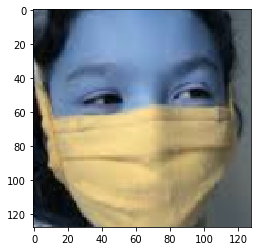

In [21]:
sample_mask_img = cv2.imread('C:/Users/jites/Downloads/Face mask detection kaggle/face mask 12k images dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img, (128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img, [1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [22]:
model.predict(sample_mask_img)

array([[0.07396337, 0.00010194]], dtype=float32)

In [24]:
# Save the model
model.save('masknet.h5')

### Integrating with haar cascade
We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [25]:
mask_label = {0:'MASK', 1:'NO MASK'}
dist_label = {0:(0,255,0), 1:(255,0,0)}

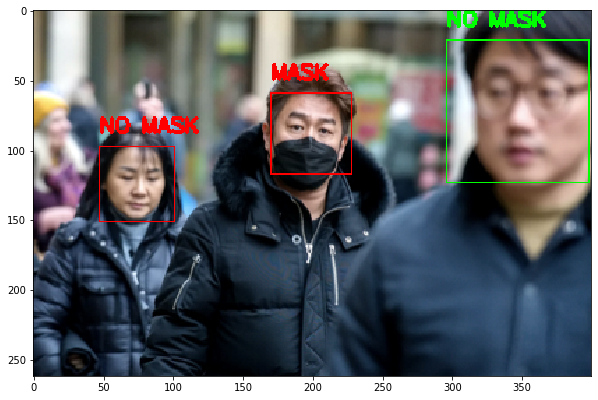

In [28]:
if(len(faces) >= 2):
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
                
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    #Colored output image
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (128,128))
        crop = np.reshape(crop, [1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img, mask_label[mask_result.argmax()], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    dist_label[label[i]],2)
        cv2.rectangle(new_img, (x,y), (x+w, y+h), dist_label[label[i]], 1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)

else:
    print("No. of faces detected is less than 2")

**Red boxes show violation of social distancing**